#### Пример работы с кодом

In [7]:
# чтобы изменения в других файлах автоматически подгружались в импорты
%load_ext IPython.extensions.autoreload
%autoreload 2

The IPython.extensions.autoreload extension is already loaded. To reload it, use:
  %reload_ext IPython.extensions.autoreload


In [8]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime as dt

from data import FinData
from preprocessing import train_valid_split, train_valid_test_split
from model import CatboostFinModel

In [23]:
data = FinData("../datasets/T_yandex_10min.csv", column_names={'Yandex open' : 'open', 
                                          'Yandex close' : 'close', 
                                          'Yandex high' : 'high', 
                                          'Yandex low' : 'low', 
                                          'Yandex volume' : 'volume'})

data.insert_all()

In [24]:
data.get_columns()

Index(['utc', 'open', 'close', 'high', 'low', 'volume', 'direction_binary',
       'close_norms_3', 'close_high_norms_3', 'high_norms_3', 'low_norms_3',
       'close_norms_6', 'close_high_norms_6', 'high_norms_6', 'low_norms_6',
       'close_norms_18', 'close_high_norms_18', 'high_norms_18',
       'low_norms_18', 'hours', 'day', 'minute', 'is_holiday', 'pred_holiday',
       'week_pred_holiday', 'day_time', 'season', 'ma_3', 'close_normed_ma_3',
       'ma_6', 'close_normed_ma_6', 'ma_18', 'close_normed_ma_18', 'ema_3',
       'close_normed_ema_3', 'ema_6', 'close_normed_ema_6', 'ema_18',
       'close_normed_ema_18', 'rsi_3', 'close_normed_rsi_3', 'rsi_6',
       'close_normed_rsi_6', 'rsi_18', 'close_normed_rsi_18', 'ma_16',
       'close_normed_ma_16', 'SD', 'upper_bollinger', 'low_bollinger',
       'close_normed_upper_bollinger', 'close_normed_low_bollinger',
       'hl_diff_3', 'close_normed_hl_diff_3', 'hl_diff_6',
       'close_normed_hl_diff_6', 'hl_diff_18', 'close_normed_

In [25]:
numeric = ['close_norms_3',
       'close_high_norms_3', 'high_norms_3', 'low_norms_3', 'close_norms_6',
       'close_high_norms_6', 'high_norms_6', 'low_norms_6', 'close_norms_18',
       'close_high_norms_18', 'high_norms_18', 'low_norms_18', 'day_time',
        'close_normed_ma_3', 'close_normed_ma_6', 'close_normed_ma_18', 'close_normed_ema_3',
       'close_normed_ema_6', 'close_normed_ema_18', 'rsi_3',
       'close_normed_rsi_3', 'rsi_6', 'close_normed_rsi_6', 'rsi_18',
       'close_normed_rsi_18', 'close_normed_ma_16', 'SD',
        'close_normed_upper_bollinger',
       'close_normed_low_bollinger', 'hl_diff_3',
       'hl_diff_6', 'hl_diff_18', 'stochastic_oscillator',
        'stochastic_oscillator_ma_3',
       'close_normed_stochastic_oscillator_ma_3', 'stochastic_oscillator_ma_6',
       'close_normed_stochastic_oscillator_ma_6',
       'stochastic_oscillator_ma_18',
       'close_normed_stochastic_oscillator_ma_18',
        'butter_filter_std', 
       'close_normed_butter_filter_trend_rsi_3',
       'close_normed_butter_filter_trend_rsi_6', 
       'close_normed_butter_filter_trend_rsi_18', 
       'close_normed_butter_filter_trend_ma_3', 
       'close_normed_butter_filter_trend_ma_6', 
       'close_normed_butter_filter_trend_ma_18',
       'butter_filter_trend_deviation',
       'close_normed_butter_filter_trend_deviation']

cat = []

args = {"iterations" : 10000, 
        "depth" : 5, 
        "learning_rate" : 0.01, # тут слегка неадекватные параметры, которые можно менять 
        "use_best_model" : True, 
        "l2_leaf_reg" : 200,
        "verbose" : 100, # отчет каждые 100 итераций 
        "loss_function" : 'CrossEntropy', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 5000}

data.restrict_time_down(dt.datetime(2024, 11, 1))

In [21]:
data.check_stationarity(columns=numeric)

c:\Users\Валерия\OneDrive\Документы\GitHub\prices-predictions\myenv\Lib\site-packages\numpy\lib\function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
c:\Users\Валерия\OneDrive\Документы\GitHub\prices-predictions\myenv\Lib\site-packages\numpy\lib\function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


Ошибка при обработке столбца 'close_normed_rsi_3': exog contains inf or nans
Ошибка при обработке столбца 'close_normed_rsi_6': exog contains inf or nans


c:\Users\Валерия\OneDrive\Документы\GitHub\prices-predictions\myenv\Lib\site-packages\numpy\lib\function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


Ошибка при обработке столбца 'close_normed_rsi_18': exog contains inf or nans
Ошибка при обработке столбца 'stochastic_oscillator': exog contains inf or nans


In [26]:
X_train, X_val, y_train, y_val = train_valid_split(data=data.df, 
                                                   year=2024, month=12, day=5, 
                                                   numeric=numeric, cat=cat, target="direction_binary")

In [27]:
model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(numeric, cat)

model.fit()

0:	learn: 0.6921713	test: 0.6414141	best: 0.6414141 (0)	total: 27.5ms	remaining: 4m 35s
100:	learn: 0.6954210	test: 0.6313131	best: 0.6414141 (0)	total: 658ms	remaining: 1m 4s
200:	learn: 0.7031019	test: 0.6414141	best: 0.6414141 (0)	total: 1.42s	remaining: 1m 9s
300:	learn: 0.7069424	test: 0.6313131	best: 0.6414141 (0)	total: 2.01s	remaining: 1m 4s
400:	learn: 0.7101920	test: 0.6262626	best: 0.6414141 (0)	total: 2.73s	remaining: 1m 5s
500:	learn: 0.7149188	test: 0.6363636	best: 0.6414141 (0)	total: 3.36s	remaining: 1m 3s
600:	learn: 0.7155096	test: 0.6464646	best: 0.6464646 (594)	total: 4s	remaining: 1m 2s
700:	learn: 0.7175775	test: 0.6464646	best: 0.6464646 (594)	total: 4.55s	remaining: 1m
800:	learn: 0.7217134	test: 0.6464646	best: 0.6515152 (720)	total: 5.09s	remaining: 58.5s
900:	learn: 0.7258493	test: 0.6565657	best: 0.6565657 (871)	total: 5.73s	remaining: 57.8s
1000:	learn: 0.7299852	test: 0.6565657	best: 0.6565657 (871)	total: 6.47s	remaining: 58.2s
1100:	learn: 0.7341211	test

In [29]:
model.print_constant_accuracy(y_val)

Точность константного предсказания 0.5404040404040404


In [30]:
model.print_feature_importances()

0.12052282033847074 day_time
0.4234302527075155 close_norms_18
0.43923600358028736 rsi_3
0.4673754813790636 close_high_norms_18
0.5333407290987892 close_high_norms_3
0.5452522355707469 close_normed_ema_18
0.5717567458386085 close_norms_3
0.7074398591956597 high_norms_18
0.7178518335141976 rsi_18
0.8130530636244412 low_norms_18
0.8380833488846277 stochastic_oscillator_ma_3
0.8525858415475703 rsi_6
0.9377346525978429 close_normed_ma_6
0.9657147887837002 stochastic_oscillator_ma_6
0.9763824066356498 close_normed_ma_18
1.133436701171836 stochastic_oscillator_ma_18
1.1513916886939264 stochastic_oscillator
1.2146362579474008 close_normed_butter_filter_trend_ma_18
1.2149147429977178 close_normed_stochastic_oscillator_ma_3
1.2577303857199458 close_high_norms_6
1.360128727736076 close_normed_ma_16
1.3951112395097744 close_norms_6
1.464492700847806 SD
1.487183782940171 hl_diff_6
1.4970875519118227 close_normed_stochastic_oscillator_ma_6
1.4983243815616227 close_normed_low_bollinger
1.52835828668

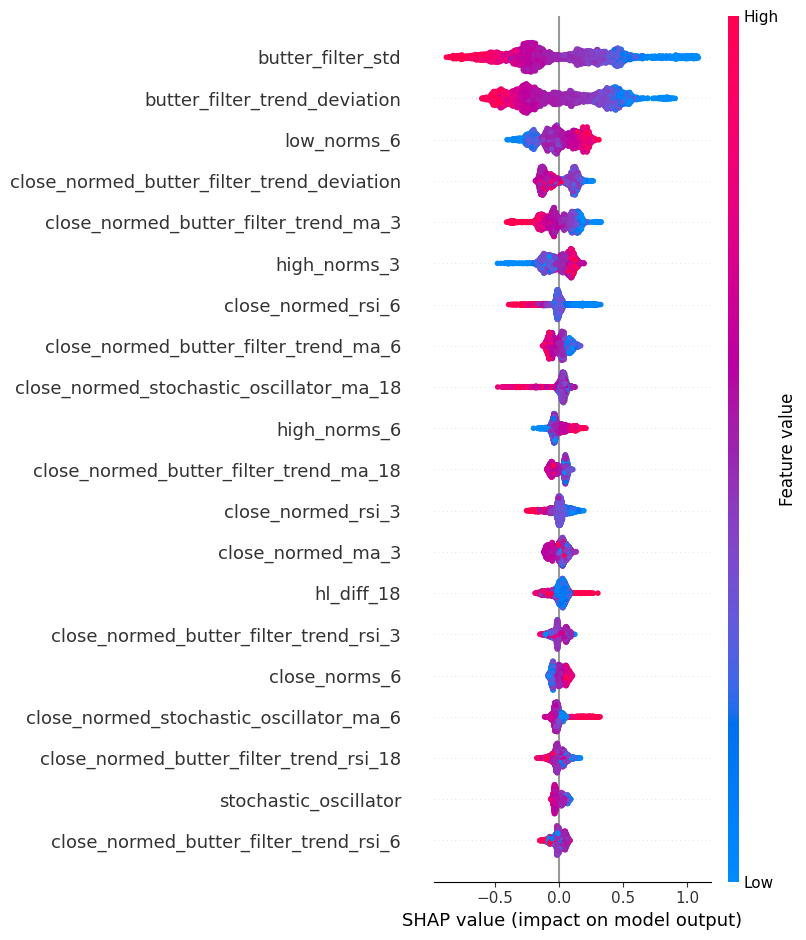

In [31]:
model.visualise_shap_values()